<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Bootstrap simulation with FACET

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.

***

**Context**

This tutorial aims to provide a step by step explanation about the simulation capabilities of FACET and is based on the Water Drilling Tutorial. If you would like further background to this tutorial we recommend reviewing Water Drilling tutorial first, however, as a brief re-cap:

Drilling a water well is very dangerous and costly. The costs of such drilling are driven by the time it takes to finalize a well in order to start pumping water from it. To reduce those costs, drillers are usually incentivized to drill at a faster pace—measured as the Rate of Penetration (ROP). Depending on soil characteristics, day rates can range from `$30,000` to `$250,000`. But there is a trade-off: Drilling faster increases the risk of incidents, such as a formation collapse or a gas infiltration. We will therefore built a machine-learning model to understand the impact of drilling speed on the incident risk, in the context of other risk factors. 

For the sake of clarity, we use a simplified dataset for this example. The dataset contains 500 observations, with each row representing a drilling operation of the past, along with a binary indicator of whether or not a well-drilling incident happened in the operation. 

Analysis in the Water Drilling tutorial identified a LGBMClassifier with a value of 15 for `min_data_in_leaf` as the best performing model among those investigated, and the final set of relevant features identified were: Weight on bit (kg), Rotation speed (rpm), Depth of operation (m), Mud density (kg/L), Rate of Penetration (ft/h), and Hole diameter (m).

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Data](#Data)  
3. [Bootstrap simulation overview](#Bootstrap-simulation-overview) 
4. [Partitioning](#Partitioning) 
5. [Creating multiple train and test splits with bootstrap resampling](#Creating-multiple-train-and-test-splits-with-bootstrap-resampling)
6. [Model fitting using resampled training sets](#Model-fitting-using-resampled-training-sets)
7. [Simulating actuals](#Simulating-actuals)
8. [Simulating response](#Simulating-response)
9. [Summary](#Summary)
10. [What can you do next?](#What-can-you-do-next?)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


# ignore irrelevant warnings that would affect the output of this tutorial notebook

import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")
warnings.filterwarnings("ignore", message=r".*`np\..*` is a deprecated alias")


# set global options for matplotlib

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
matplotlib.rcParams["figure.dpi"] = 72

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
# list your usual imports here such as pandas, numpy and others 
# not covered by FACET, sklearndf or pytools
import numpy as np
import pandas as pd
import seaborn as sns

**FACET imports**

In [3]:
from facet.crossfit import LearnerCrossfit
from facet.data import Sample
from facet.data.partition import (
    ContinuousRangePartitioner,
    IntegerRangePartitioner,
    CategoryPartitioner,
)
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.validation import BootstrapCV

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import ClassifierPipelineDF
from sklearndf.classification.extra import LGBMClassifierDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
from pytools.viz.distribution import ECDFDrawer

# Data

Based on the water well drilling tutorial, we select a feature set all most linearly independent with the Rate of Penetration (ROP).

In [6]:
# load the prepared dataframe
df = pd.read_csv(
    "water_drilling_classification_data.csv",
    sep=";",
    encoding="utf-8",
)

# relevant features identified in previous tutorial
feature_set = ['Weight on bit (kg)', 'Rotation speed (rpm)',
               'Depth of operation (m)', 'Mud density (kg/L)',
               'Rate of Penetration (ft/h)', 'Hole diameter (m)']

# create a FACET sample object
drilling_obs = Sample(observations=df, 
                      target_name="Incident", 
                      feature_names=feature_set)

# quick look
drilling_obs.features.head()

feature,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (ft/h),Hole diameter (m)
observation,,,,,,
0,289.201651,10594.222670,790.947541,2.898840,28.403279,5.369813
1,341.949835,6962.659505,811.833996,1.677378,27.066685,5.580490
2,266.831213,11065.697315,619.497649,2.213403,30.556081,4.374240
3,267.340585,7890.678632,1048.481202,2.683010,23.735377,6.981177
4,305.977342,12017.344224,613.434303,2.360972,28.502248,4.217036


# Bootstrap simulation overview

The figure above provides and overview of the simulation process for a single bootstrap split. This process is repeated many time to create a distribution of predicted impact for each value of a feature.

<img src="../_static/Facet-Simulator-BlockDiagram.png" width="750">


## Partitioning

The first step to simulate feature effects on the target is to set the scope of the study for the feature we want to simulate. Let's take the ROP measured in feet per hour (ft/h) as the feature to simulate.

The plot below shows that the ROP is centered around 25 ft/h with a range of 10 to 40ft/h.

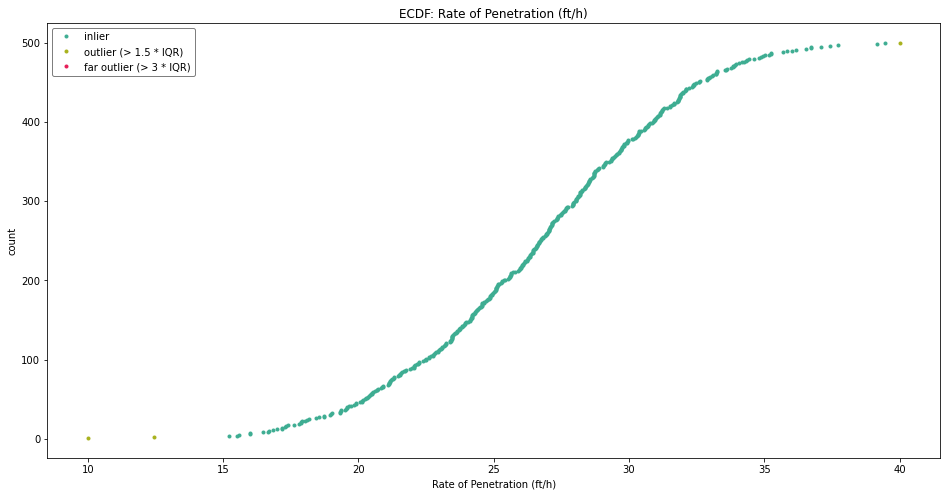

In [7]:
SIM_FEATURE = "Rate of Penetration (ft/h)"
ECDFDrawer().draw(drilling_obs.features[SIM_FEATURE])

As ROP is a continuous variable we use the `ContinuousRangePartitioner()` to generate partitions.

In [8]:
# instantiate the partitioner
rop_bins = ContinuousRangePartitioner()

# fit the partitioner on the observations' distribution
rop_bins.fit(values=drilling_obs.features[SIM_FEATURE])

# check bins are fitted
rop_bins.is_fitted

True

Now let's visualize what the partitioner provides. In the plot below each bar is a partition created by the `ContinuousRangePartitioner()`. `rop_bins.partitions_` provided the bin mid-points, `rop_bins.frequencies_` provided the count of observations for each partition, and `rop_bins.partition_width_` specified the width of our partitions.

The default behaviour of the `ContinuousRangePartitioner()` and `IntegerRangePartitioner()` is to exclude the tail values (2.5th and 97.5th percentiles) of the feature. So, the total number of observations binned is < *n* (the number of observations). In this case, the partitions encompass 478 of 500 observations (95.6%). The default upper and lower bounds can be changed using the `upper_bound` and `lower_bound` arguments of the `ContinuousRangePartitioner()` and `IntegerRangePartitioner()`, 
e.g. 

```python
rop_bins = ContinuousRangePartitioner(lower_bound=10., upper_bound=40.)
```

<AxesSubplot:xlabel='Rate of Penetration (ft/h)', ylabel='Density'>

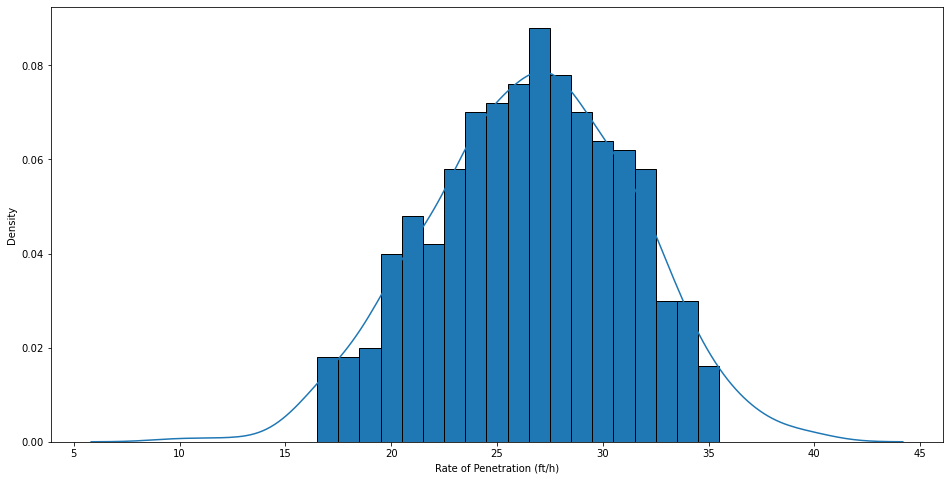

In [9]:
plt.bar(
    x=rop_bins.partitions_,
    height=rop_bins.frequencies_/drilling_obs.features.shape[0],
    width=rop_bins.partition_width_,
    edgecolor="k"
)

sns.kdeplot(data=drilling_obs.features[SIM_FEATURE])

If you want to know the bounds for each partition you can use `rop_bins.partition_bounds_`. A quick way to list the midpoint and bounds for each partition is as follows:

In [10]:
list(zip(rop_bins.partitions_, rop_bins.partition_bounds_))

[(17.0, (16.5, 17.5)),
 (18.0, (17.5, 18.5)),
 (19.0, (18.5, 19.5)),
 (20.0, (19.5, 20.5)),
 (21.0, (20.5, 21.5)),
 (22.0, (21.5, 22.5)),
 (23.0, (22.5, 23.5)),
 (24.0, (23.5, 24.5)),
 (25.0, (24.5, 25.5)),
 (26.0, (25.5, 26.5)),
 (27.0, (26.5, 27.5)),
 (28.0, (27.5, 28.5)),
 (29.0, (28.5, 29.5)),
 (30.0, (29.5, 30.5)),
 (31.0, (30.5, 31.5)),
 (32.0, (31.5, 32.5)),
 (33.0, (32.5, 33.5)),
 (34.0, (33.5, 34.5)),
 (35.0, (34.5, 35.5))]

The above example utilized the `ContinuousRangePartitioner()`. FACET has three variations of partitioner available depending on the feature type, `ContinuousRangePartitioner()`, `IntegerRangePartitioner()` and `CategoryPartitioner()`. In summary: 

- The `CategoryPartitioner()` will create a partition for each unique value of the feature. If the number of partitions < number of unique values in the category, the top n partition frequent categories will be used.

- The `IntegerRangePartitioner()` will subdivide the feature range of values into almost equal-sized partitions while ensuring the partition bounds are integers. Each partition is represented by an integer value. If your integer feature is positive or strictly positive or has an upper bound, be sure to use the `lower_bound` and/or `upper_bound` arguments.

- The `ContinuousRangePartitioner()` will subdivide the feature range of values into equal-sized partitions. Each partition is represented by the partition mid-point.

## Creating multiple train and test splits with bootstrap resampling

Bootstrapping is the process of resampling data with replacement to generate a data set of the same size as the original. Bootstrapping lends itself naturally to use as a cross-validation mechanism as we get a training dataset of the same size as the original data representing a theoretical draw from the same population as the original data, and a hold-out test set of unique observations also from a similar population as the original dataset and with a reasonable size (~37%).

In [11]:
# instantiate bootstrap cross validation iterator with 1000 splits
boot_cv = BootstrapCV(n_splits=1000, random_state=42)

# extract the sample index for the first test-train split
(train_split_1, test_split_1) = next(boot_cv.split(X=drilling_obs.features, y=drilling_obs.target))

# calculate charateristics of indexes for first split
print(f"Original dataset n = {drilling_obs.features.shape[0]}")
print(f"Resampled training set n = {len(train_split_1)}")
print(f"Resampled training set number of unique values = {len(np.unique(train_split_1))}")
print(f"Test set n = {len(test_split_1)}")
print(f"Overlap between index for train and test = {list(set(train_split_1) & set(test_split_1))}")

Original dataset n = 500
Resampled training set n = 500
Resampled training set number of unique values = 300
Test set n = 200
Overlap between index for train and test = []


As we can see, in the first split we have a training set of 500 observations (the same size as the original dataset) that contains 300 unique observations sampled from the original dataset. The remaining 200 observations the were not sampled are put aside as the test split. This represents a single bootstrap split. Further, because the training set for each bootstrap is those observations that were not sampled, this number can vary from split to split, while the size of the training set is constant.

In [12]:
# extract index lengths for each bootstrap test train split
rows = [[len(train_index), len(test_index)] for train_index, test_index in boot_cv.split(X=drilling_obs.features, y=drilling_obs.target)]
num_obs_df = pd.DataFrame(rows, columns=['n_train', 'n_test'])
num_obs_df.describe()

,n_train,n_test
count,1000.0,1000.000000
mean,500.0,184.029000
std,0.0,6.771263
min,500.0,162.000000
25%,500.0,179.000000
50%,500.0,184.000000
75%,500.0,189.000000
max,500.0,205.000000


Hence, in this example we can see that we have generated 1000 training datasets of 500 observations, while the size of the training set varies between 162 and 205, with a median size of 184 (36.8%) which is a little over one third of the data.

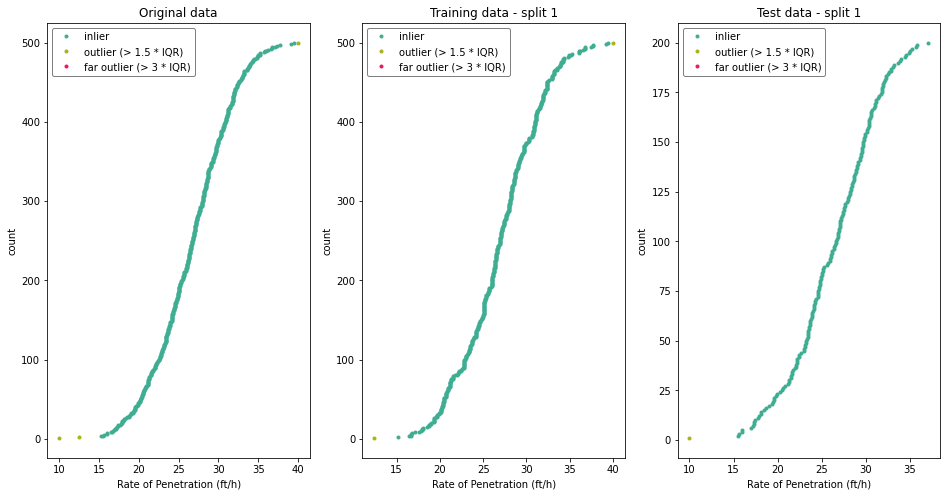

In [13]:
# compare ECDF for test and train first split with original
plt.subplot(1, 3, 1)
ECDFDrawer().draw(data=drilling_obs.features.loc[:, SIM_FEATURE], title='Original data')
plt.subplot(1, 3, 2)
ECDFDrawer().draw(data=drilling_obs.features.loc[train_split_1, SIM_FEATURE], title='Training data - split 1')
plt.subplot(1, 3, 3)
ECDFDrawer().draw(data=drilling_obs.features.loc[test_split_1, SIM_FEATURE], title='Test data - split 1')

We can also see that bootstrap resampling with sufficient sample size provides feature distributions in the train and test sets that are representative of the original data. 

## Model fitting using resampled training sets

With our resampled training sets the idea is to use the model we identified previously and fit the model on each one in order to generate a series of models that will give slightly different predictions for the same feature combination.

In [14]:
# best perfoming light gradient boosting learner identified previously
lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42, min_child_samples=15),
)

# instantiate the crossfit
boot_crossfit = LearnerCrossfit(
    pipeline=lgbm_clf,
    cv=boot_cv,
    n_jobs=-3,
    verbose=1,
)

# fit the model
boot_crossfit.fit(sample=drilling_obs, verbose=-1)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed:   22.6s finished


After fitting the crossfit, `boot_crossfit.models()` contains the model fitted on each resampled training set. We can check this as follows:

In [15]:
model_split_1 = next(boot_crossfit.models())
model_split_1.is_fitted

True

We can also get a sense of the variation in prediction for a single feature combination across the different splits and hence, trained models.

In [16]:
single_test_obs = drilling_obs.features.loc[2:2]
rows = [model.predict_proba(X=single_test_obs)[1].ravel() for model in boot_crossfit.models()]
pred_df = pd.DataFrame(rows, columns=['pred_prob'])

In [17]:
pred_df['pred_prob'].describe()

count    1000.000000
mean        0.187645
std         0.293122
min         0.000658
25%         0.006171
50%         0.011662
75%         0.279029
max         0.996891
Name: pred_prob, dtype: float64

In this case for the observation we choose, we see that the 1000 models produce an average predicted probability of the positive class of 0.03 with an IQR of 0.003 to 0.015.

## Simulating actuals

For each test split we can predict the outcome and look at the deviation between the average prediction for a test split and the actual average of the target in the original dataset. The spread and offset of these deviations can serve as an indication of how the bias of the model contributes to the uncertainty of simulations.

In [18]:
# instantiate simulator
rop_simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, n_jobs=-3)

In [19]:
# simulate average difference between 
actual_distribution = rop_simulator.simulate_actuals()

Median: -0.000683
lower bound: -0.0558
upper bound: 0.0525


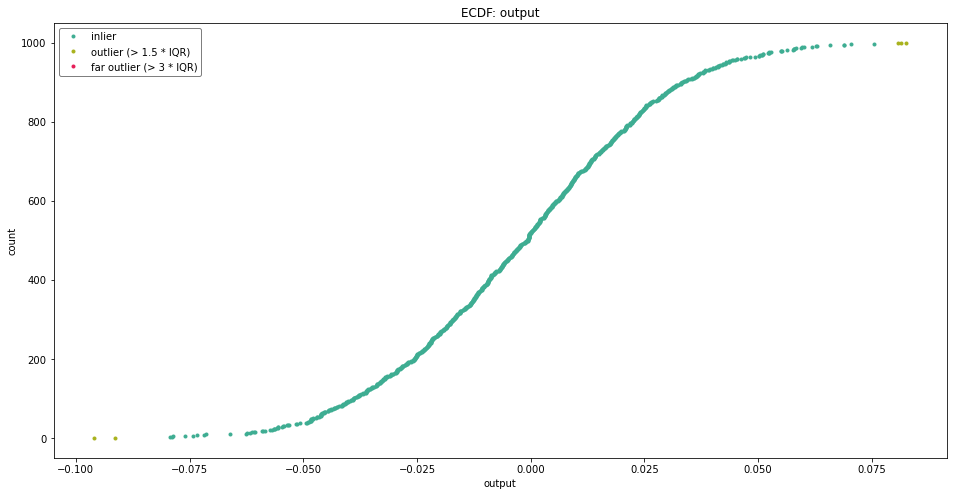

In [20]:
ECDFDrawer().draw(actual_distribution)

print(f"Median: {np.median(actual_distribution):.3g}")
print(f"lower bound: {np.percentile(actual_distribution, 2.5):.3g}")
print(f"upper bound: {np.percentile(actual_distribution, 97.5):.3g}")

In our case, the model's deviation does not exceed 6% of the target.

Now to convince ourselves that this indeed works, lets grab the fitted model and the test set for the first split in our cross fit and see if we can re-produce the number for the first split.

In [21]:
model_split_1 = next(boot_crossfit.models())
train_split_1, test_split_1 = next(boot_crossfit.splits())

yhat_split_1 = model_split_1.predict_proba(X=drilling_obs.features.loc[test_split_1, :])[1]

print(f"actual mean predicted uplift: {actual_distribution[0]}")
print(f"reproduced actual mean predicted uplift: {yhat_split_1.mean() - drilling_obs.target.mean()}")

actual mean predicted uplift: -0.023030198104474375
reproduced actual mean predicted uplift: -0.023030198104474375


## Simulating response

With the 1000 bootstrap splits in place and our preferred model trained on each each resampled training split, the last step is to perform prediction for the partitions of the selected feature. For each test set the selected feature is set equal to the value for a partition and the outcome predicted using the trained model for that split. The average value of the outcome is then calculated. This is repeated for each partition and in our example we have 19 partitions, so one bootstrap split will yield 19 values (one for each split). This is repeated for every bootstrap split, so with a 1000 splits, we end up with 1000 by 19 average predicted values. This means for each partition we have a distribution of a 1000 values from which we can summarize to describe the likely outcome (and associated variability) for a specific value of our feature.

In [22]:
# first run the simulator
rop_simulation = rop_simulator.simulate_feature(feature_name=SIM_FEATURE, partitioner=rop_bins)

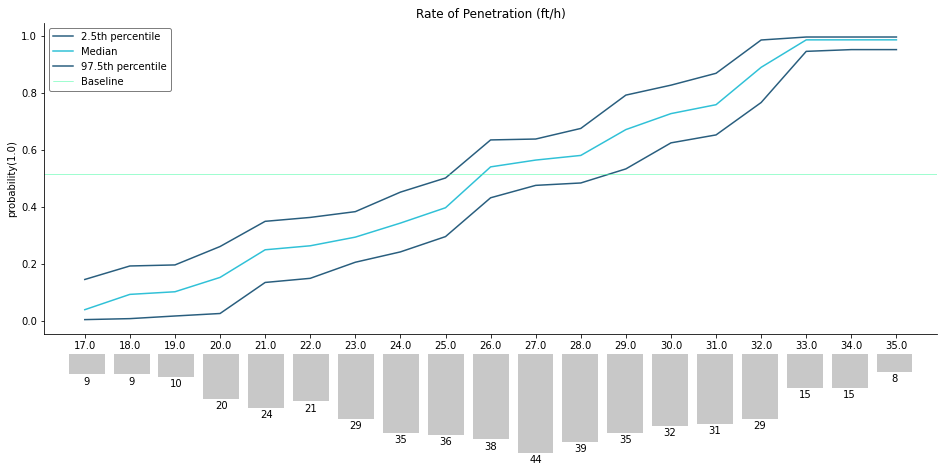

In [23]:
# now draw the output 
SimulationDrawer().draw(data=rop_simulation, title=SIM_FEATURE)

For each partition bin (grey bar under the x-axis) thanks to bootstrapping we have a distribution of 1000 values for each, and we can access these values as shown below.

In [24]:
rop_simulation.outputs.head()

partition,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
split,,,,,,,,,,,,,,,,,,,
0,0.049906,0.049906,0.166919,0.265232,0.312876,0.297162,0.299539,0.299052,0.335352,0.529027,0.538611,0.532143,0.586882,0.778060,0.750020,0.957752,0.994613,0.994652,0.994663
1,0.091842,0.091842,0.100337,0.193954,0.203056,0.252020,0.238959,0.263947,0.309629,0.498949,0.588171,0.559805,0.731027,0.679344,0.895259,0.897717,0.982798,0.982671,0.982671
2,0.009679,0.009679,0.024988,0.025052,0.123883,0.126408,0.209497,0.366908,0.366153,0.583650,0.593623,0.606231,0.619351,0.638837,0.691888,0.817875,0.994545,0.994545,0.994545
3,0.021690,0.122891,0.106262,0.106659,0.225007,0.267777,0.269421,0.423507,0.459069,0.656906,0.555915,0.561615,0.788436,0.826636,0.793199,0.986338,0.992405,0.992395,0.992393
4,0.021572,0.124259,0.124259,0.177597,0.263064,0.249085,0.223781,0.226017,0.413647,0.529550,0.569325,0.606052,0.714682,0.764587,0.771251,0.868054,0.987244,0.988662,0.988662


Taking the bin centered at 23.0 as an example we can plot the distribution of the probability of the outcome as follows and show the median, 2.5th and 97.5th percentiles which are the values shown for this partition in the plot above.

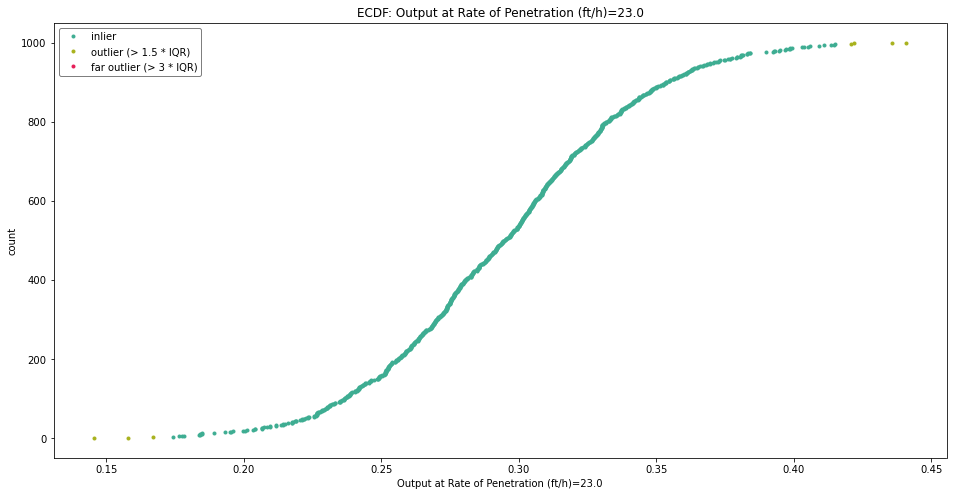

In [25]:
SIM_VALUE = 23.0
ECDFDrawer().draw(rop_simulation.outputs[SIM_VALUE].rename(f"Output at {SIM_FEATURE}={SIM_VALUE}"))

For this partition we could also see that for the first split the average predicted probability of the outcome was 0.30.

In [26]:
rop_simulation.outputs.loc[0, SIM_VALUE]

0.29953861017735744

To confirm our understanding of how the number was generated, we can take the test data and model from the first split generated as part of the bootstrap-crossfit and calculate it.

In [27]:
model_split_1 = next(boot_crossfit.models())
(train_split_1, test_split_1) = next(boot_crossfit.splits())
test_split_1_modified = drilling_obs.features.loc[test_split_1]
test_split_1_modified[SIM_FEATURE] = SIM_VALUE
model_split_1.predict_proba(X=test_split_1_modified)[1].mean()

0.29953861017735744

As expected this single value among the 1000 generated for this partition is the average predicted probability of the outcome in the first bootstrap test set using the selected model trained on the first bootstrap resample. 

# Summary

**Partitioning**

1. Select the right partitioner for your type of feature: categorical, integer or continuous.
2. Note that feature partitions are derived from the full dataset and the tail values of the observations will be excluded for integer and float type features (unles. 

**Creating multiple train and test splits with bootstrap resampling**

3. The bootstrap resampling produces *m* training sets of size *n* and *m* test sets on average of size 0.368*n*. On average a training set will contain 0.632*n* unique observations from the original data.
4. The resampling creates train and test sets the are representative of the original data. 

**Model fitting using resampled training sets**

5. The selected model is fit on each training set and so each split will generate a slightly different prediction for the same feature combination. 

**Simulating actuals**

6. The spread and offset of the deviations between the average predicted value for the test set and the average of the target in the original dataset can serve as an indication of how the bias of the model may contribute to uncertainty in simulation.

**Simulating response**

7. The bootstrap average predictions for each partition yields a distribution of expected values for the target for that partition.

# What can you do next?

1. Try out using a different feature for simulation
2. Create a different feature type and try using a different partitioner
3. Create a model for a dataset with a continuous target and try out the `UnivariateTargetSimulator` and the `UnivariateUpliftSimulator`.